In [2]:
import pandas as pd # IMPORTS
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [ ]:
bankDF = pd.read_csv("../Base.csv") # Utilize the dataset that best represents the original dataset
y_true = bankDF['fraud_bool']

In [96]:
bankDF.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

In [97]:
# Quantify the employment status, 1 if CA, otherwise 0
bankDF['employment_status'] = bankDF['employment_status'].apply(lambda x: 1 if x == 'CA' else 0)
bankDF['device_os_windows'] = bankDF['device_os'].apply(lambda x: 1 if x == 'windows' else 0)
bankDF['housing_status_BA'] = bankDF['housing_status'].apply(lambda x: 1 if x == 'BA' else 0)

# Natural log scaling for these categories
bankDF.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                     int64
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

<AxesSubplot: >

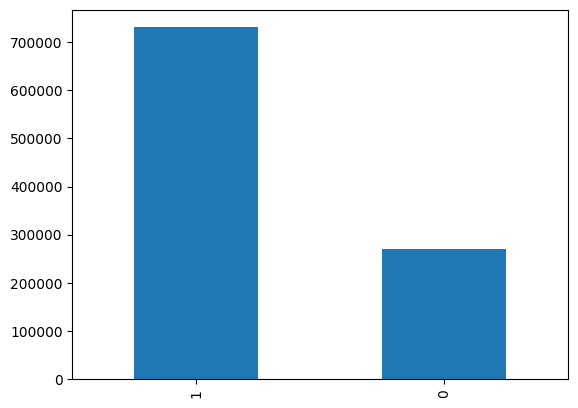

In [49]:
bankDF['employment_status'].value_counts().plot(kind='bar')

<AxesSubplot: ylabel='Frequency'>

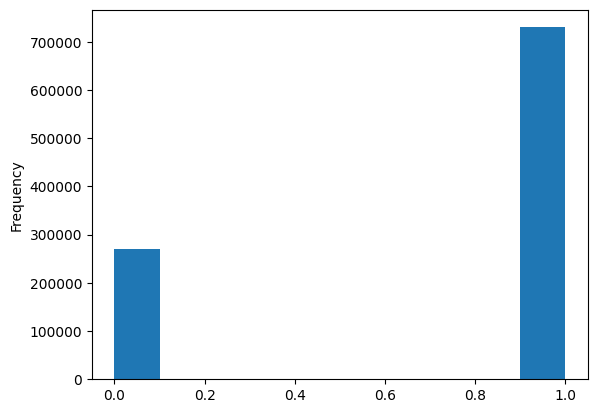

In [50]:
bankDF.employment_status.plot.hist() # Experiment with the data

Text(0, 0.5, 'fraud_bool')

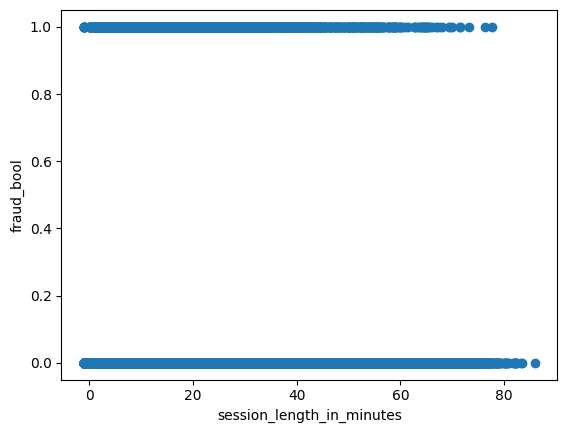

In [5]:
plt.scatter(bankDF['session_length_in_minutes'], bankDF['fraud_bool'])
plt.xlabel('session_length_in_minutes')
plt.ylabel('fraud_bool')

In [6]:
def train(isf, ensemble, sample_size, filtered_data):
    model_list = list()
    for i in range(ensemble):
        to_train = filtered_data.sample(sample_size)
        temp = isf.fit(to_train)
        model_list.append(temp)
    return model_list

def predict(model_list, X_test):
    pass1 = list()
    for model in model_list:
        y_pred = model.predict(X_test)
        y_pred_binary = [1 if x == -1 else 0 for x in y_pred]
        pass1.append(y_pred_binary)
    res = list() # Get a "vote" for which classification each model thinks would work best
    for j in range(len(pass1[0])): # Iterates through each prediction
        count_zero = 0
        count_one = 0
        for i in range(len(pass1)): # Iterates through each model's prediction set
            if pass1[i][j] == 0:
                count_zero += 1
            else:
                count_one += 1
        if (count_zero > count_one):
            res.append(0)
        else:
            res.append(1)
    return res

In [66]:
used_cols = ["income","name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request", "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w", "credit_risk_score", "email_is_free", "phone_home_valid", "phone_mobile_valid", "bank_months_count", "has_other_cards", "proposed_credit_limit", "foreign_request", "session_length_in_minutes", "keep_alive_session", "employment_status", "device_os_windows", "housing_status_BA"] #, "foreign_request", "device_distinct_emails_8w"]
# filtered_data = bankDF[used_cols]
# X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42) # Random state same as the other one, use 30% for testing
# X_train.head()

In [91]:
# Cell for feature engineering one model to test it out
isf = IsolationForest(n_estimators=100, max_samples='auto',
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

In [98]:
good_cols = bankDF[used_cols]
random_cols = ['housing_status_BA', 'device_os_windows']
filtered_data = good_cols[random_cols]
X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42)
model_list = train(isf, 7, 30000, filtered_data)
y_processed = y_test.values
y_pred_binary = predict(model_list, X_test)
roc = roc_auc_score(y_processed, y_pred_binary)
roc

0.718172587976131

In [9]:
"""
Use this block to find the best randomly chosen features thus far. It'll test 1 to 23 features and print out the best set
"""
good_cols = bankDF[used_cols]
isf = IsolationForest(n_estimators=100, max_samples='auto',
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

# isf.fit(X_train, isf)
best_roc = 0
best_cols = list()
for n in range(1, 23):
    for x in range(70):
        random_cols = np.random.choice(good_cols.columns, size=n, replace=False) # How many random features to take

        filtered_data = good_cols[random_cols]
        X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42)
        model_list = train(isf, 5, 30000, filtered_data)
        y_processed = y_test.values
        y_pred_binary = predict(model_list, X_test)
        roc = roc_auc_score(y_processed, y_pred_binary)
        if roc > best_roc:
            best_roc = roc
            best_cols = random_cols
            print("Best Columns: ")
            print(random_cols)
            print("Best ROC AUC: " + str(roc))

Best Columns: 
['keep_alive_session']
Best ROC AUC: 0.5
Best Columns: 
['customer_age']
Best ROC AUC: 0.5969967901419008
Best Columns: 
['proposed_credit_limit']
Best ROC AUC: 0.6052023132488998
Best Columns: 
['proposed_credit_limit']
Best ROC AUC: 0.6055005079076775
Best Columns: 
['credit_risk_score' 'customer_age']
Best ROC AUC: 0.6076006951151186
Best Columns: 
['proposed_credit_limit' 'foreign_request']
Best ROC AUC: 0.6099634673146788
Best Columns: 
['proposed_credit_limit' 'velocity_24h' 'customer_age']
Best ROC AUC: 0.6130861154354708
Best Columns: 
['customer_age' 'proposed_credit_limit' 'session_length_in_minutes'
 'credit_risk_score' 'foreign_request' 'keep_alive_session']
Best ROC AUC: 0.6277952173040097


In [64]:
"""
More thorough approach. Test each combination of each feature
"""
good_cols = bankDF[used_cols]
isf = IsolationForest(n_estimators=100, max_samples='auto',
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

# isf.fit(X_train, isf)
random_cols = ['proposed_credit_limit', 'customer_age', 'credit_risk_score', 'name_email_similarity', 'customer_age', 'keep_alive_session', 'velocity_4w']
for n in range(1, 17):
    best_roc = 0
    best_col = ""
    for new_feature in used_cols:
        if new_feature not in random_cols:
            random_cols.append(new_feature) # Grab the next feature

            filtered_data = good_cols[random_cols]
            X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42)
            model_list = train(isf, 5, 30000, filtered_data)
            y_processed = y_test.values
            y_pred_binary = predict(model_list, X_test)
            roc = roc_auc_score(y_processed, y_pred_binary)

            if roc > best_roc and roc > 0.6:
                best_roc = roc
                best_col = new_feature
                print("Best Columns: ")
                print(random_cols)
                print("Best ROC AUC: " + str(roc))
            random_cols.pop() # Remove this feature to test another one at this size
    random_cols.append(best_col)
    # Append the best feature we found for this size to random_cols

Best Columns: 
['proposed_credit_limit', 'customer_age', 'credit_risk_score', 'name_email_similarity', 'customer_age', 'keep_alive_session', 'velocity_4w', 'income']
Best ROC AUC: 0.6386612648611467
Best Columns: 
['proposed_credit_limit', 'customer_age', 'credit_risk_score', 'name_email_similarity', 'customer_age', 'keep_alive_session', 'velocity_4w', 'foreign_request']
Best ROC AUC: 0.6437577077310614
Best Columns: 
['proposed_credit_limit', 'customer_age', 'credit_risk_score', 'name_email_similarity', 'customer_age', 'keep_alive_session', 'velocity_4w', 'foreign_request', 'income']
Best ROC AUC: 0.6339177337381219
Best Columns: 
['proposed_credit_limit', 'customer_age', 'credit_risk_score', 'name_email_similarity', 'customer_age', 'keep_alive_session', 'velocity_4w', 'foreign_request', 'zip_count_4w']
Best ROC AUC: 0.6385472860414455
Best Columns: 
['proposed_credit_limit', 'customer_age', 'credit_risk_score', 'name_email_similarity', 'customer_age', 'keep_alive_session', 'velocity_

KeyboardInterrupt: 

In [60]:
"""
Now that we have a baseline to work off of... Try to add one more features to random_cols and see if anything yields something promising
"""
best_roc = 0.6
best_new_col = ""
for new_feature in used_cols:
    if new_feature not in random_cols:
        random_cols.append(new_feature)
        filtered_data = good_cols[random_cols]
        X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42)
        model_list = train(isf, 7, 30000, filtered_data)
        y_processed = y_test.values
        y_pred_binary = predict(model_list, X_test)
        roc = roc_auc_score(y_processed, y_pred_binary)
        if roc > best_roc:
            best_roc = roc
            best_new_col = new_feature
            print(new_feature)
            print(roc)
    random_cols.pop() # Remove that feature to test the next one
            

KeyboardInterrupt: 

In [59]:
# y_processed = y_test.values
# y_pred = isf.predict(X_test) # predict detects if it's an inliner, where inliners are 1 and outliers are -1
# y_pred_binary = [1 if x == -1 else 0 for x in y_pred] # Turn it into what we want with 1 being an outlier and 0 being an inlier
y_processed = y_test.values
y_pred_binary = predict(model_list, X_test)
roc = roc_auc_score(y_processed, y_pred_binary)
roc

0.6444493364214572

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
conf_matrix

array([[227605,  69181],
       [  2272,    942]])